# Introduction

# Prerequisite

## Download data

In [ ]:
#!wget --directory-prefix=../data/ https://figshare.com/ndownloader/files/25030028

In [3]:
#!mv ../data/25030028 ../data/pancreas_preprocessed.h5ad

In [ ]:
#!wget --directory-prefix=../data/ https://figshare.com/ndownloader/files/25060877

In [4]:
#!mv ../data/25060877 ../data/pancreas.h5ad

## Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [3]:
adata_preprocessed = sc.read('../data/pancreas_preprocessed.h5ad')
adata_preprocessed.var_names_make_unique
adata_preprocessed

AnnData object with n_obs × n_vars = 2531 × 2000
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'dpt_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'diffmap_evals', 'iroot', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_diffmap', 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 

In [4]:
adata = sc.read('../data/pancreas.h5ad')
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
U = adata.layers['unspliced'].toarray()
S = adata.layers['spliced'].toarray()

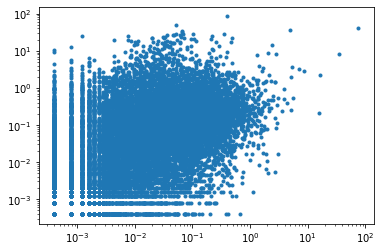

In [6]:
plt.loglog(U.mean(axis=0),S.mean(axis=0),'.');

## Select cells

In [23]:
cell_mask = adata.obs['clusters'].isin(['Alpha','Beta', 'Fev+'])
subdata = adata[cell_mask]
subdata

View of AnnData object with n_obs × n_vars = 1655 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

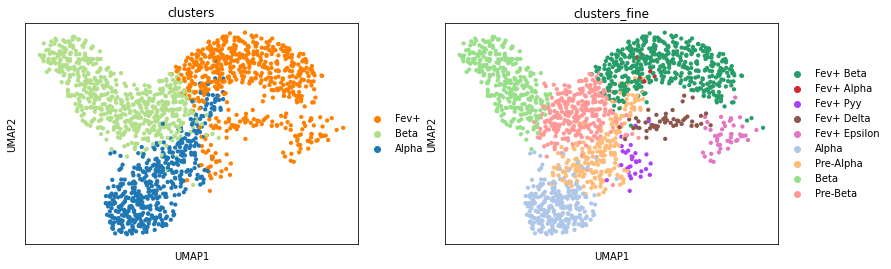

In [24]:
sc.pl.umap(subdata, color=['clusters','clusters_fine'])

## Select genes

In [25]:
marker_genes = ['Pyy', 'Rbp4','Chgb','Fev', 'Cck', 'Neurod1','Vwa5b2','Tox3','Tmem9','Fam183b']

In [26]:
marker_mask = subdata.var_names.isin(marker_genes)

In [27]:
sc.pp.highly_variable_genes(subdata,n_top_genes=2000,flavor="seurat_v3")
gene_mask = marker_mask | (subdata.var['highly_variable']) & (subdata.layers["unspliced"].toarray().mean(axis=0) > 1) & (subdata.layers["spliced"].toarray().mean(axis=0) > 1)
fitted_genes = subdata.var_names[gene_mask]
print(np.sort(fitted_genes))

Trying to set attribute `.uns` of view, copying.


['Abcc8' 'Actb' 'Ank' 'Cck' 'Chgb' 'Cpe' 'Fam183b' 'Fev' 'Glud1' 'Gng12'
 'Grb10' 'Hspa8' 'Ins2' 'Meg3' 'Meis2' 'Neurod1' 'Nnat' 'Pak3' 'Pam'
 'Pcsk2' 'Pim2' 'Ppp3ca' 'Pyy' 'Rbp4' 'Rnf130' 'Runx1t1' 'Tmem163' 'Tmem9'
 'Tox3' 'Vwa5b2' 'Zbtb20']


In [28]:
plot_idx = np.arange(len(fitted_genes))[fitted_genes.isin(marker_genes)]
fitted_genes[plot_idx]

Index(['Fev', 'Tmem9', 'Fam183b', 'Pyy', 'Vwa5b2', 'Rbp4', 'Neurod1', 'Chgb',
       'Tox3', 'Cck'],
      dtype='object', name='index')

## Get X

In [29]:
X = np.zeros((np.sum(cell_mask),np.sum(gene_mask),2))
X[:,:,0] = subdata.layers["unspliced"].toarray()[:,gene_mask]
X[:,:,1] = subdata.layers["spliced"].toarray()[:,gene_mask]
X.shape

(1655, 31, 2)

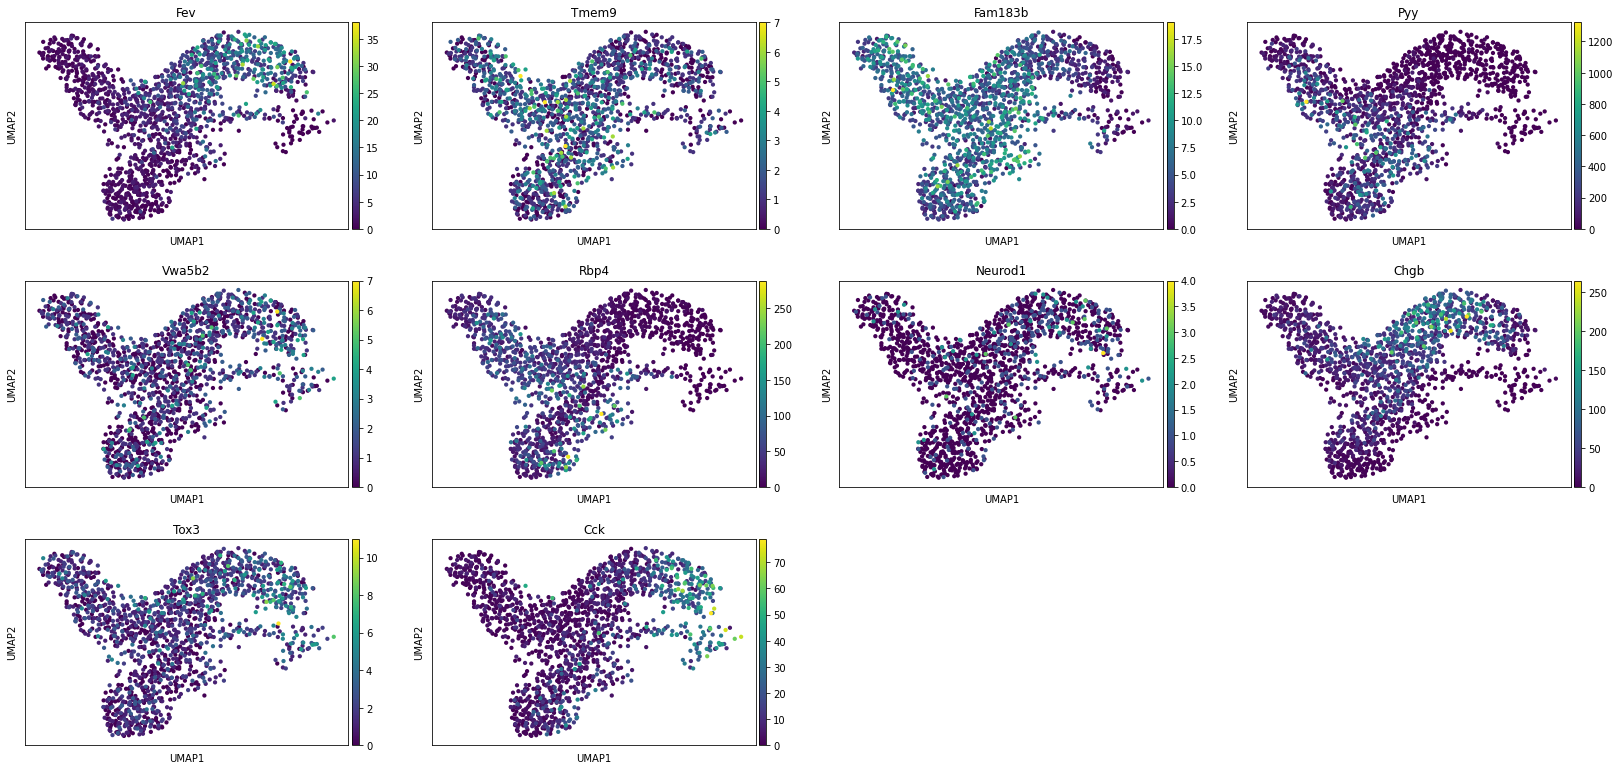

In [30]:
sc.pl.umap(subdata, color=fitted_genes[plot_idx])

# Fitting

## Warm start

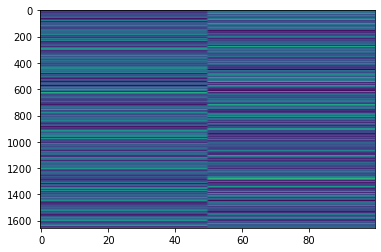

In [31]:
n, p, _ = X.shape
m = 100
Q0 = np.zeros((n,2,m))
Q0[subdata.obs['clusters'].isin(['Fev+']),:,:50]=1
Q0[subdata.obs['clusters'].isin(['Alpha']),0,50:]=1
Q0[subdata.obs['clusters'].isin(['Beta']),1,50:]=1
Q0 = Q0/np.sum(Q0,axis=0,keepdims=True)
plt.imshow(Q0[:,0],aspect='auto');

In [32]:
t = Q0[:,0]@np.linspace(0,1,100)

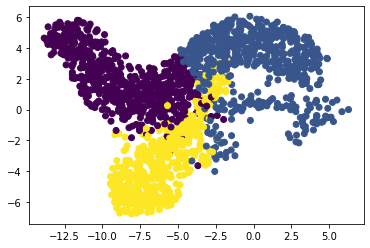

In [33]:
plt.scatter(subdata.obsm['X_umap'][:,0],subdata.obsm['X_umap'][:,1],c=t)

In [36]:
topo = np.array([[0],[1]])
tau = (0,1) # ~24 hours
traj = Trajectory(topo, tau, model='two_species_ss')
traj = traj.fit(X,Q=Q0,parallel=True,n_threads=4)

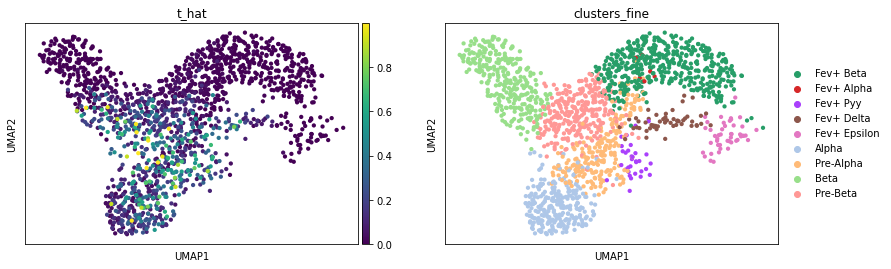

In [40]:
subdata.obs["t_hat"]=traj.Q[:,0]@traj.t
sc.pl.umap(subdata,color=["t_hat","clusters_fine"])

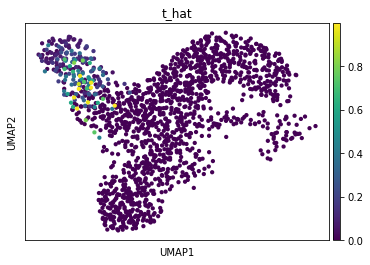

In [43]:
subdata.obs["t_hat"]=traj.Q[:,1]@traj.t
sc.pl.umap(subdata,color=["t_hat"])

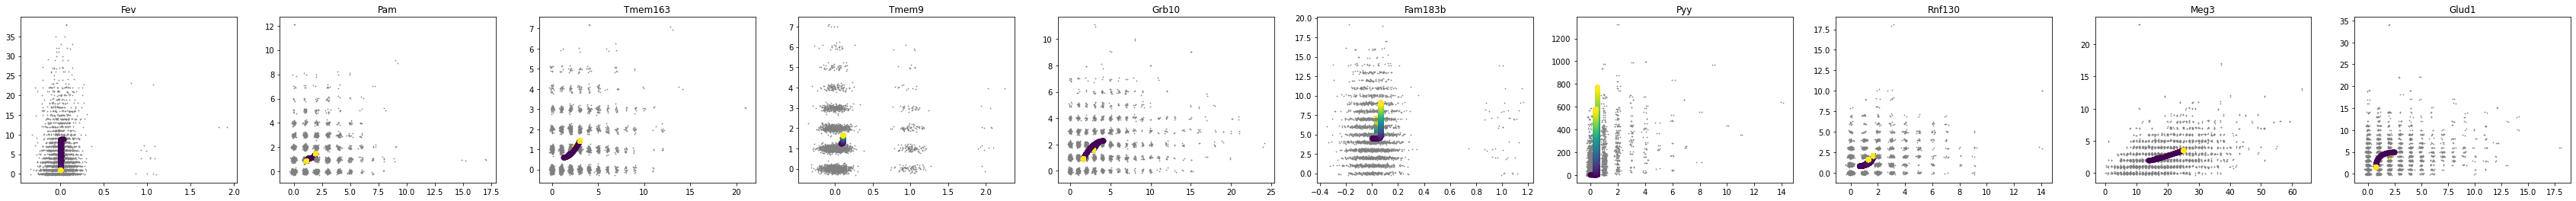

In [46]:
plot_phase(traj,idx=np.arange(10),gene_name=fitted_genes)

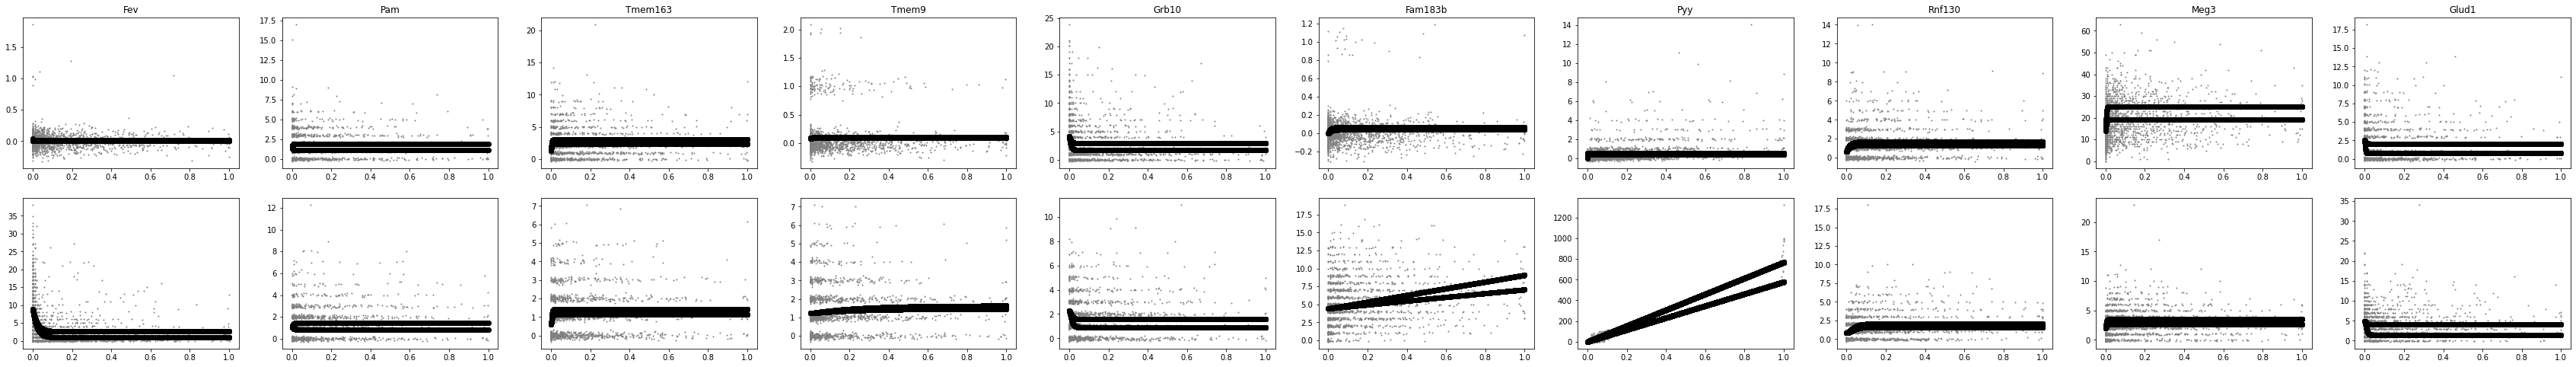

In [48]:
plot_y(traj,idx=np.arange(10),gene_name=fitted_genes)

## Random initializations

In [19]:
topo = np.array([[0],[1],[2],[3]])
tau = (0,1) # ~24 hours
traj = Trajectory(topo, tau,model="two_species_ss",verbose=1)
traj = traj.fit(X,m=100,n_init=3,parallel=True,n_threads=2)

run method fit_multi_init
trial 1


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]

trial 2



100%|██████████| 20/20 [00:20<00:00,  1.05s/it]

trial 3



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


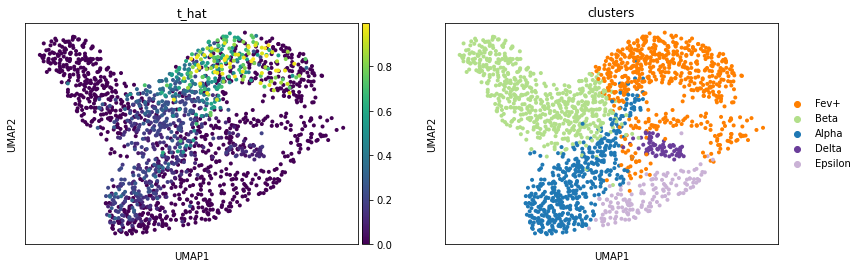

In [23]:
subdata.obs["t_hat"]=traj.Q[:,0]@traj.t
sc.pl.umap(subdata,color=["t_hat","clusters"])

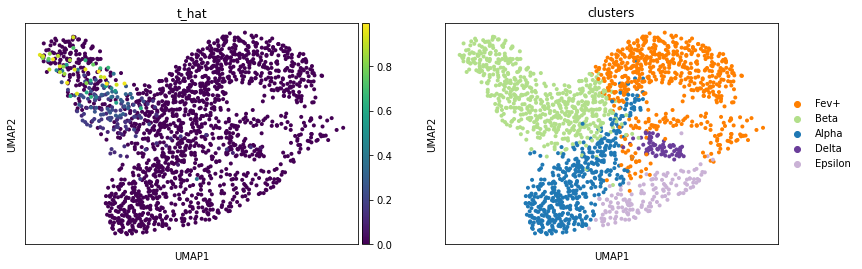

In [25]:
subdata.obs["t_hat"]=traj.Q[:,1]@traj.t
sc.pl.umap(subdata,color=["t_hat","clusters"])

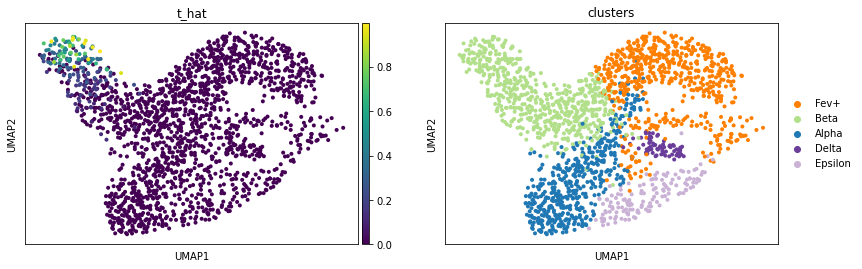

In [26]:
subdata.obs["t_hat"]=traj.Q[:,2]@traj.t
sc.pl.umap(subdata,color=["t_hat","clusters"])

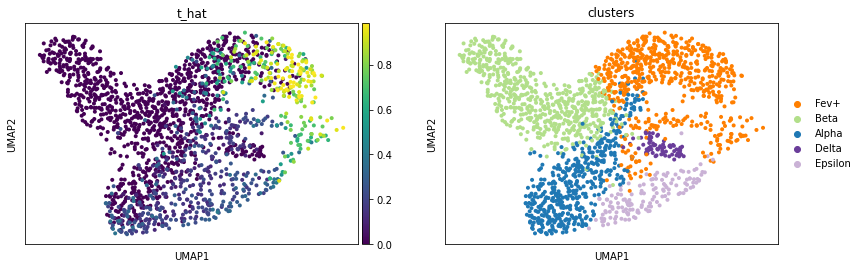

In [27]:
subdata.obs["t_hat"]=traj.Q[:,3]@traj.t
sc.pl.umap(subdata,color=["t_hat","clusters"])

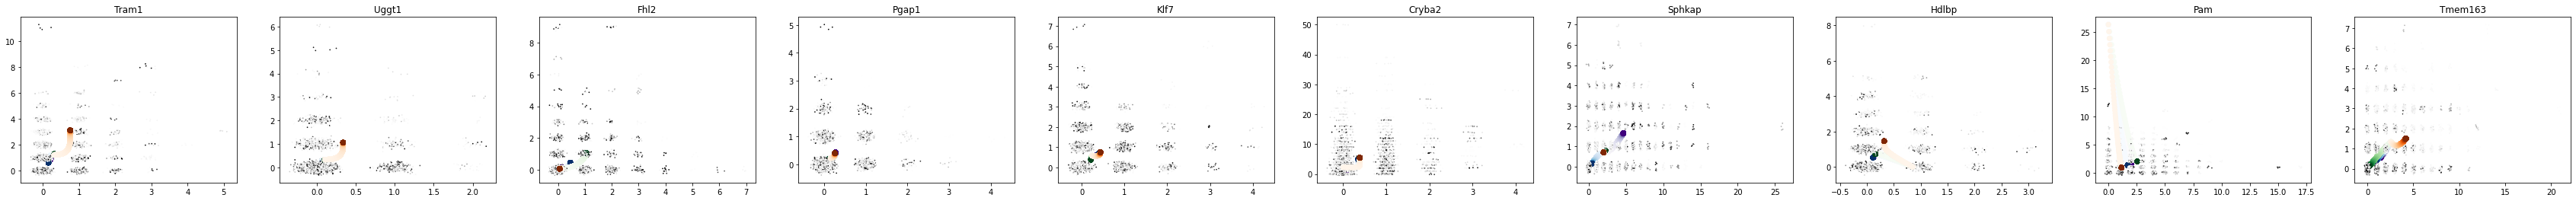

In [86]:
plot_phase(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)

In [ ]:
plot_y(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)